<a href="https://colab.research.google.com/github/Lakemonsters2635/Colabs/blob/main/Roboflow_Deploy_Custom_Mobilenet_to_OAK_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roboflow, DepthAI, and Lake Monsters: Train and Deploy a custom object detection model with depth! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)


<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500"><br>

![1359057916[1].png](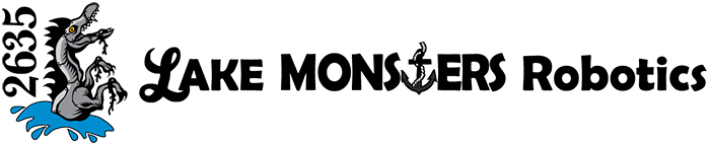)


We highly recommend working through this notebook with the corresponding blog post in hand. 

A Major shoutout to Luxonis, the creators of the OAK-D Device for originally putting this tutorial together. Here, we streamline the training process with data management, transformation, and exportation from Roboflow. 

At the end of this tutorial, you will have a custom trained object detection model to deploy to your OAK-D device!

# Prepare Your Training Data

Assuming you have your annotated data stored on Roboflow, you'll need prepare it for export.  Export it in Tensorflow TFRecord format.  Select the ````show download code```` option and click ````Continue````.

Select the ````Terminal```` tab of the next dialog box.  You'll see a box containing a command beginning with ````curl````.  Copy just the URL to your clipboard.  Include the quotes.  We'll use this in a moment.

A few cells further down from here, you'll find a cell with the 1st line:

  `dataset_name = Cargo`

* Change `Cargo` to the base directory of your data.
* Paste the URL you just copied to replace the nonsense one on the line beginning with ````CURL_URL =````.




## Please note the weird behavior of the 1st executable cell.
The best way to run this Colab is:
1.    Select the 1st Code cell (the one containing ````!pip install numpy....````).
2.    Run just that selection by either typing ````Ctrl-Shift-Enter```` or using the menu item ````Runtime | Run Selection````.
3.    Click the ````Restart Runtime```` button that will eventually appear in the output portion of the cell.
4.    Run the entire Colab by typing ````Ctrl-F9````.  The 1st cell will run again.  But since numpy has now been installed, it will simply note this fact and continue with the remaining cells.





# Install Training Environment Dependencies and Configs

In [ ]:
# %%capture
#After this cell executes runtime will restart to finish the install, ignore and close the crash message, continue running cells starting with the one below
!pip install numpy==1.17.5;


# Update the following cell before running this Colab

* Change "Cargo" to the actual name of your dataset from Roboflow.
* Change the URL to the actual URL you got from Roboflow's Export feature.

In [ ]:
dataset_name = "Cargo"

CURL_URL = "https://app.roboflow.com/ds/klsdchvioweuhcbvweouhf"

In [ ]:
%tensorflow_version 1.x
!pip install tf_slim

In [ ]:

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.

num_steps = 5000  # A step means using a single batch of data. larger batch, less steps required
#60000 steps is required to train our example sign language dataset, less or more may be required based on your custom datasets needs

#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 24
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Install Tensorflow Object Detection API

Clone TF models which contains the Object Detection API; also install the required dependencies


In [ ]:
# %%capture
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

In [ ]:
import os

repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull


## Prepare `tfrecord` files



In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

!curl -L "https://app.roboflow.com/ds/0opSe3AZEm?key=OHP67Gp6mK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


In [ ]:
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/' + {dataset_name} + '.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/' + {dataset_name} + '.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/' + {dataset_name} + '_label_map.pbtxt'


In [ ]:
#double check that our class names came through

%cat {label_map_pbtxt_fname}


In [ ]:
!ls '/content/tensorflow-object-detection-faster-rcnn/data/'

## Download the Mobilenet SSD v2 Model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

In [ ]:
#TF pretrained model checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re
iou_threshold = 0.50
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    print(pipeline_fname)
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    # Set number of classes num_classes.
    s = re.sub('iou_threshold: [0-9].[0-9]+',
               'iou_threshold: {}'.format(iou_threshold), s)
    
    f.write(s)

In [ ]:
# #Have a look at the config file with various settings
!cat {pipeline_fname}

# Train Custom Mobilenet Model


In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory for a fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

#training will take a while (the TF OD library is not heavily optimized for speed on GPU), watch the mAP metrics rise, you can quit training early when you think your model has maxed out performance

In [ ]:
#model dir check for the trained model
!ls {model_dir}

## Export a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
#clean output_directory if necessary to start fresh:

# !rm -rf /content/object_detection_demo/fine_tuned_model/ 
# os.makedirs('/content/object_detection_demo_flow/fine_tuned_model/', exist_ok=True)

In [ ]:
%%capture
import re
import numpy as np

output_directory = './fine_tuned_model'
# output_directory = '/content/gdrive/My\ Drive/data/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [ ]:
#export directory check
# !ls {output_directory}

In [ ]:
import os
pb_fname = os.path.join(os.path.abspath(output_directory), "saved_model/saved_model.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
# !ls -alh {pb_fname}

In [ ]:
#download frozen graph for posterity, you can keep this so you don't have to start over on training
from google.colab import files
files.download(pb_fname)

## Running Inference: Checking what the trained model can detect
Test with images in repository `tensorflow-object-detection-faster-rcnn/data/images/final test` directory.

In [ ]:
#You will need to import test images into the test folder specified below - In Roboflow you can export raw images in YOLO Darknet format

test_folder = '/content/tensorflow-object-detection-faster-rcnn'
sample_img = 'https://storage.googleapis.com/roboflow-platform-transforms/D7CAGZafFYZMvKbKibZGc42BUAx2/56694b0cb356d57b9da4914993042958/transformed.jpg'

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR = test_folder + "/data/test/"

import urllib.request
urllib.request.urlretrieve(sample_img, 
                           PATH_TO_TEST_IMAGES_DIR + "language.jpg")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    PATH_TO_CKPT = '/content/models/research/fine_tuned_model/frozen_inference_graph.pb'
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

# Convert TF model to OpenVINO 20.01 Intermediate Representation (IR)
 This can be used to run inference on OpenVINO.
# In order to run the model on DepthAI modules, we then compile the IR obtained above to a .blob (via a server we set up just for that) 

## First, we install Open Vino 20.01


In [ ]:
%cd ../..

In [ ]:
%%time
# %%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
!wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
path = "l_openvino_toolkit_p_2020.1.023.tgz"
# path = "/content/software/Intel OpenVINO 2019 R3.1/l_openvino_toolkit_p_2019.3.376.tgz"
## install openvino
!tar xf "{path}"
# !tar xf "{path}" && \
#     cd l_openvino_toolkit_p* && \
#     ./install_openvino_dependencies.sh && \
#     sed -i 's/decline/accept/g' silent.cfg && \
#     ./install.sh
# ## install dependencies
# !/opt/intel/openvino/install_dependencies/install_openvino_dependencies.sh
# ## install prerequisites
# !/opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

In [ ]:
%%capture
%cd l_openvino_toolkit_p_2020.1.023/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

In [ ]:
!ls

[Optional] Open Vino install check, generally not needed

In [ ]:
!source /opt/intel/openvino/bin/setupvars.sh && \
    /opt/intel/openvino/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

### Here we run some modifications in the ssd2 OpenVINO extension for TF so that our Mobilenet SSDv2 model can convert successfully to the IR

In [ ]:
%cd /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/
#openvino fixes: edit 
# Read in the file, make sure the .json corresponds to the model!!!
with open('ssd_v2_support.json', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('"Postprocessor/ToFloat"', '"Postprocessor/Cast_1"')

# Write the file out again
with open('ssd_v2_support.json', 'w') as file:
  file.write(filedata)


In [ ]:
%cp "/content/models/research/fine_tuned_model/saved_model/saved_model.pb" "/content/models/research/fine_tuned_model/"

## Convert TF model to Open Vino Intermediate Representation
If using own model, please change to your desired name for output directory --output_dir "choose name"

In [ ]:
#CONVERT TF MODEL to OPEN VINO IRv10. saved in IR_V10_fruits_mnssdv2_6k directory or
#choose own name for --output_dir "choose name"
%cd "/content/models/research/fine_tuned_model/"
!source /opt/intel/openvino/bin/setupvars.sh && \
    python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
    --input_model frozen_inference_graph.pb \
    --tensorflow_use_custom_operations_config /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
    --tensorflow_object_detection_api_pipeline_config pipeline.config \
    --reverse_input_channels \
    --output_dir signs \
    --data_type FP16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#check directory containing the exported TF trained model and the IRv10 folder
%ls 

## Now we compile the IR model to a .blob for use on DepthAI modules/platform

---



### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename will be *frozen_inference_graph.blob*

In [ ]:
%ls /content/models/research/fine_tuned_model/signs

In [ ]:
#No changes needed here unless using custom data.
#CHOOSE the directory where you would like to save the blob.
# I use the same --output_dir as above for the IR conversion
blob_dir = "/content/models/research/fine_tuned_model/signs/"

#Copy the path of your .xml and .bin files. For that, you can look at the IR
#conversion output cell, select and copy from:
#[SUCCESS] XML file and bin file paths.
#Or you can choose to compile other .xml .bin files from a different location
#
xmlfile = "/content/models/research/fine_tuned_model/signs/frozen_inference_graph.xml"
binfile = "/content/models/research/fine_tuned_model/signs/frozen_inference_graph.bin"

import requests

#For openvino 20.01 use this link to compile the blob
url = "http://69.164.214.171:8080"


#open vino 20.02 link:
# url = "69.164.214.171:8081"

payload = {'compiler_params': '-ip U8 -VPU_MYRIAD_PLATFORM VPU_MYRIAD_2480 -VPU_NUMBER_OF_SHAVES 4 -VPU_NUMBER_OF_CMX_SLICES 4'}
files = [
  ('definition', open(xmlfile,'rb')),
  ('weights', open(binfile,'rb'))
]
# headers = {
#   'Content-Type': 'application/json'
# }
response = requests.request("POST", url, data = payload, files = files)
blobnameraw = response.headers.get('Content-Disposition')
print(blobnameraw)
blobname = blobnameraw[blobnameraw.find('='):][1:]
with open(blob_dir + blobname, 'wb') as f:
  f.write(response.content)

In [ ]:
from google.colab import files
files.download('/content/models/research/fine_tuned_model/signs/frozen_inference_graph.blob')

## To run the .blob in DepthAI, we proceed step 5 here:
 https://docs.luxonis.com/tutorials/object_det_mnssv2_training/